Let's start with the necessary imports and setup commands:

In [13]:
%matplotlib inline

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.graphics.gofplots import ProbPlot
from scipy.stats import zscore
from scipy.stats import rankdata

plt.style.use('seaborn') # pretty matplotlib plots
plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=18)

Loading the data, and getting rid of `NA`s:

In [2]:
auto = pd.read_csv('../../../../data/ISLR/datasets/Auto.csv', na_values=['?'])
auto.dropna(inplace=True)
auto.reset_index(drop=True, inplace=True)

The fitted linear regression model, using statsmodels R style formula API:

In [3]:
model_f = 'mpg ~ cylinders + \
                 displacement + \
                 horsepower + \
                 weight + \
                 acceleration + \
                 year + \
                 origin'

model = smf.ols(formula=model_f, data=auto)

model_fit = model.fit()

Calculations required for some of the plots: 

In [4]:
# fitted values (need a constant term for intercept)
y_pred = model_fit.predict(sm.add_constant(auto[['cylinders', 
                                               'displacement', 
                                               'horsepower', 
                                               'weight', 
                                               'acceleration', 
                                               'year', 
                                               'origin']]))

# model residuals
model_residuals = model_fit.resid

# normalized residuals
model_norm_residuals = zscore(model_fit.resid)

# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))

# absolute residuals
model_abs_resid = np.abs(model_residuals)

# leverage, from statsmodels internals
model_leverage = model_fit.get_influence().hat_matrix_diag

# cook's distance, from statsmodels internals
model_cooks = model_fit.get_influence().cooks_distance[0]

And now, the actual plots:

### 1. Residual plot

First plot that's generated by `plot()` in R is the **residual plot**, which draws a scatterplot of fitted values against residuals, with a "locally weighted scatterplot smoothing (lowess)" regression line showing any apparent trend.

This one can be easily plotted using seaborn `residplot` with fitted values as `x` parameter, and the dependent variable as `y`. `lowess=True` makes sure the lowess regression line is drawn. Additional parameters are passed to underlying matplotlib scatter and line functions using `scatter_kws` and `line_kws`, also titles and labels are set using matplotlib methods. The `;` in the end gets rid of the output text `<matplotlib.text.Text at 0x000000000>` at the top of the plot <sup>[1](https://stackoverflow.com/questions/38968404/hide-matplotlib-descriptions-in-jupyter-notebook)</sup>. Top 3 absolute residuals are also annotated:

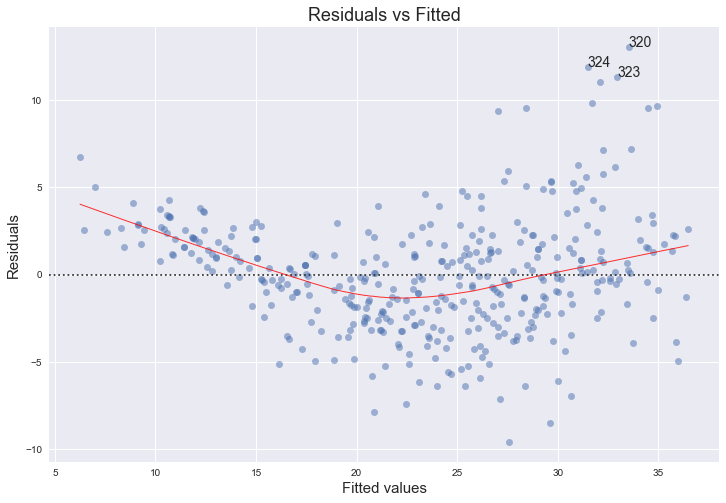

In [9]:
plot_lm_1 = plt.figure(1)
plot_lm_1.set_figheight(8)
plot_lm_1.set_figwidth(12)

plot_lm_1.axes[0] = sns.residplot(y_pred, 'mpg', data=auto, 
                          lowess=True, 
                          scatter_kws={'alpha': 0.5}, 
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals')


# annotations
abs_resid = model_abs_resid.sort_values(ascending=False)
abs_resid_top_3 = abs_resid[:3]

for i in abs_resid_top_3.index:
    plot_lm_1.axes[0].annotate(i, 
                               xy=(y_pred[i], 
                                   model_residuals[i]));

### 2. QQ plot

This one shows how well the distribution of residuals fit the normal distribution. This plots the standardized (z-score) residuals against the theoretical normal quantiles. Anything quite off the diagonal lines may be a concern for further investigation.

For this, I'm using `ProbPlot` and its `qqplot` method from statsmodels graphics API. statsmodels actually has a qqplot method that we can use directly, but it's not very customizable, hence this two-step approach. Annotations were a bit tricky, as theoretical quantiles from `ProbPlot` are already sorted:

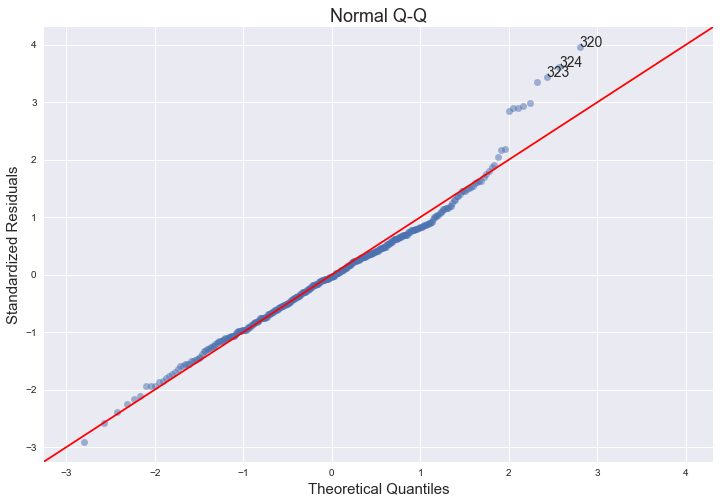

In [10]:
QQ = ProbPlot(model_norm_residuals)
plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)

plot_lm_2.set_figheight(8)
plot_lm_2.set_figwidth(12)

plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals');

# annotations
abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
abs_norm_resid_top_3 = abs_norm_resid[:3]

for r, i in enumerate(abs_norm_resid_top_3):
    plot_lm_2.axes[0].annotate(i, 
                               xy=(np.flip(QQ.theoretical_quantiles, 0)[r], 
                                   model_norm_residuals[i]));

### 3. Scale-Location Plot

This is another residual plot, showing the spread that you can use the assess heteroscedasticity.

It's just a scatter plot of absolute squared normalized residuals and fitted values, with a lowess regression line. Scatterplot is a standard matplotlib function, lowess line comes from seaborn `regplot`. Top 3 absolute square-rooted residuals are also annotated:

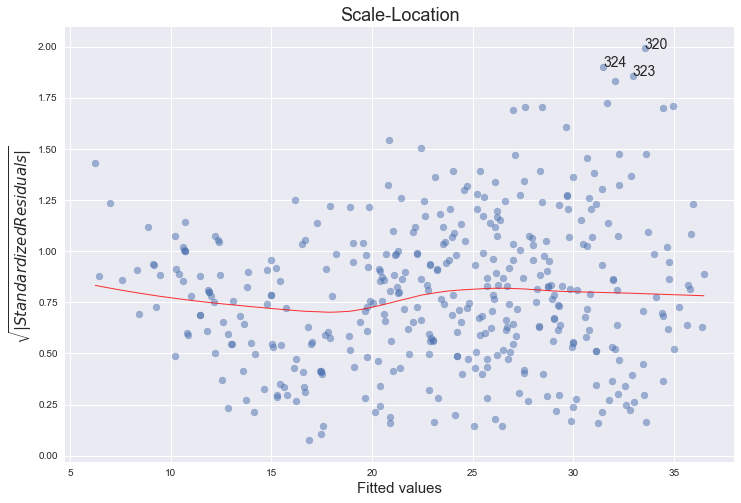

In [11]:
plot_lm_3 = plt.figure(3)
plot_lm_3.set_figheight(8)
plot_lm_3.set_figwidth(12)

plt.scatter(y_pred, model_norm_residuals_abs_sqrt, alpha=0.5)
sns.regplot(y_pred, model_norm_residuals_abs_sqrt, 
            scatter=False, 
            ci=False, 
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_3.axes[0].set_title('Scale-Location')
plot_lm_3.axes[0].set_xlabel('Fitted values')
plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');

# annotations
abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]

for i in abs_norm_resid_top_3:
    plot_lm_3.axes[0].annotate(i, 
                               xy=(y_pred[i], 
                                   model_norm_residuals_abs_sqrt[i]));

### 4. Leverage plot

This plot shows if any outliers have influence over the regression fit. Anything outside the group and outside "Cook's Distance" lines, may have an influential effect on model fit.

statsmodels has a built-in leverage plot for linear regression, but again, it's not very customizable. Digging around the source of the `statsmodels.graphics` package, it's pretty straightforward to implement it from scratch and customize with standard matplotlib functions. There are three parts to this plot: First is the scatterplot of leverage values (got from statsmodels fitted model using `get_influence().hat_matrix_diag`) vs. standardized residuals. Second one is the lowess regression line for that. And the third and the most tricky part is the Cook's distance lines, which currently I couldn't figure out how to draw in Python. But statsmodels has Cook's distance already calculated, so we can use that to annotate top 3 influencers on the plot:

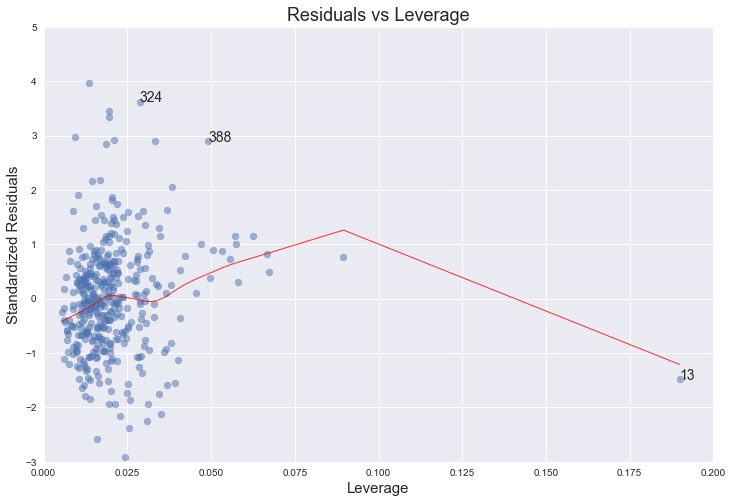

In [12]:
plot_lm_4 = plt.figure(4)
plot_lm_4.set_figheight(8)
plot_lm_4.set_figwidth(12)

plt.scatter(model_leverage, model_norm_residuals, alpha=0.5)
sns.regplot(model_leverage, model_norm_residuals, 
            scatter=False, 
            ci=False, 
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_4.axes[0].set_xlim(0, 0.20)
plot_lm_4.axes[0].set_ylim(-3, 5)
plot_lm_4.axes[0].set_title('Residuals vs Leverage')
plot_lm_4.axes[0].set_xlabel('Leverage')
plot_lm_4.axes[0].set_ylabel('Standardized Residuals')

# annotations
leverage_top_3 = np.flip(np.argsort(model_cooks), 0)[:3]

for i in leverage_top_3:
    plot_lm_4.axes[0].annotate(i, 
                               xy=(model_leverage[i], 
                                   model_norm_residuals[i]));